In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import sys
sys.path.append('../')
from utils import *

In [2]:
train_feats = pd.read_csv('../feature_eng/example_features2.csv')

## Replace infs

In [3]:
train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

counter = 0
new_columns = {}
for col in cols:
    if col != 'id' and col != 'score':
        new_columns[col] = counter
        counter += 1

train_feats.rename(columns=new_columns, inplace=True)

In [4]:
# for col in train_feats.columns:
#     if len(train_feats[col].unique()) == 1:
#         train_feats.drop(col,inplace=True,axis=1)

# len(train_feats.columns)

## Training

In [5]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [6]:
def objective(trial,data=train_feats[train_cols],target=train_feats[target_col]):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    params = {
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4,0.6,0.8,1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.4,0.6,0.8,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 5e-2, log=True), #trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [9,11,13,15,17,20,25,30]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [7,9,11,13,15,17,20,25,30]),
        'num_leaves': trial.suggest_int('num_leaves', 10, 40, step=2)
    }

    all_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': 42,
        "n_estimators" : 1000,
        "verbosity": -1,
        "n_jobs": -1,
        # "device_type": 'cuda',
        # "gpu_use_dp": True,
        **params
    }

    model = lgb.LGBMRegressor(**all_params)

    early_stopping_callback = lgb.early_stopping(50, first_metric_only=True, verbose=False)
    
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)], #verbose=False,
                callbacks=[early_stopping_callback],
    )
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [7]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-12-19 18:17:08,114] A new study created in memory with name: no-name-329ff7a4-ab9b-4472-a5b9-5b93083c55a0
[I 2023-12-19 18:17:10,324] Trial 0 finished with value: 0.6045714377491451 and parameters: {'reg_lambda': 3.0354896654458905, 'reg_alpha': 0.0005876846416982104, 'colsample_bytree': 0.4, 'colsample_bynode': 1.0, 'subsample': 0.6, 'learning_rate': 0.0017262552896301654, 'max_depth': 17, 'min_child_samples': 13, 'num_leaves': 24}. Best is trial 0 with value: 0.6045714377491451.
[I 2023-12-19 18:17:13,854] Trial 1 finished with value: 0.6613171561146926 and parameters: {'reg_lambda': 2.960287004523662, 'reg_alpha': 0.0015984380390479487, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'subsample': 0.6, 'learning_rate': 0.0010650550903436023, 'max_depth': 11, 'min_child_samples': 9, 'num_leaves': 34}. Best is trial 0 with value: 0.6045714377491451.
[I 2023-12-19 18:17:16,492] Trial 2 finished with value: 0.760257000350393 and parameters: {'reg_lambda': 0.0005131696153843017,

Number of finished trials: 100
Best trial: {'reg_lambda': 1.7759947918469, 'reg_alpha': 0.0006084005467547028, 'colsample_bytree': 0.4, 'colsample_bynode': 0.6, 'subsample': 0.5, 'learning_rate': 0.04068267327526416, 'max_depth': 20, 'min_child_samples': 30, 'num_leaves': 18}


In [8]:
study.trials_dataframe().sort_values(by='value', ascending=True)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bynode,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
92,92,0.555598,2023-12-19 18:18:48.852460,2023-12-19 18:18:49.205459,0 days 00:00:00.352999,0.6,0.4,0.040683,20,30,18,0.000608,1.775995,0.5,COMPLETE
28,28,0.556082,2023-12-19 18:17:51.262004,2023-12-19 18:17:51.719002,0 days 00:00:00.456998,0.4,0.4,0.022450,13,30,12,0.000298,0.371435,0.8,COMPLETE
51,51,0.556111,2023-12-19 18:18:19.825297,2023-12-19 18:18:20.694293,0 days 00:00:00.868996,0.4,0.6,0.013110,25,30,18,0.000170,1.941061,0.5,COMPLETE
18,18,0.556546,2023-12-19 18:17:38.106305,2023-12-19 18:17:39.626883,0 days 00:00:01.520578,0.6,0.4,0.006526,30,30,16,0.002155,0.191867,0.8,COMPLETE
83,83,0.556601,2023-12-19 18:18:43.533178,2023-12-19 18:18:44.036682,0 days 00:00:00.503504,0.4,0.6,0.029399,25,30,18,0.000223,1.857105,0.5,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,1,0.661317,2023-12-19 18:17:10.325001,2023-12-19 18:17:13.853216,0 days 00:00:03.528215,0.8,1.0,0.001065,11,9,34,0.001598,2.960287,0.6,COMPLETE
9,9,0.726493,2023-12-19 18:17:29.354796,2023-12-19 18:17:32.849753,0 days 00:00:03.494957,0.8,0.6,0.000683,20,15,36,0.000163,0.078120,1.0,COMPLETE
2,2,0.760257,2023-12-19 18:17:13.855216,2023-12-19 18:17:16.492987,0 days 00:00:02.637771,1.0,0.6,0.000579,20,20,38,1.945066,0.000513,0.5,COMPLETE
4,4,0.916921,2023-12-19 18:17:19.772457,2023-12-19 18:17:22.134813,0 days 00:00:02.362356,0.6,0.4,0.000158,15,9,24,0.030664,0.000217,0.5,COMPLETE


## Use best params

In [9]:
# best_trial = {'reg_lambda': 0.007610692291211848, 'reg_alpha': 0.00035884181589566146, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.04940151750736715, 'max_depth': 20, 'min_child_samples': 13, 'num_leaves': 22}

In [10]:
best_trial = study.best_trial.params
print(best_trial)

{'reg_lambda': 1.7759947918469, 'reg_alpha': 0.0006084005467547028, 'colsample_bytree': 0.4, 'colsample_bynode': 0.6, 'subsample': 0.5, 'learning_rate': 0.04068267327526416, 'max_depth': 20, 'min_child_samples': 30, 'num_leaves': 18}


In [22]:
OOF_PREDS = np.zeros((len(train_feats), 2))
# TEST_PREDS = np.zeros((len(test_feats), 2))

models_dict = {}
scores = []
preds_dict = {}
count = 0
for _ in train_feats['id'].unique():
    preds_dict[count] = []
    count+=1

# test_predict_list = []

for i in range(3):
    kf = model_selection.KFold(n_splits=20, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_feats.shape[0])
    # X_test = test_feats[train_cols]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]
        best_params = {
                "objective": "rmse",
                "metric": "rmse",
                'random_state': 42,
                "n_estimators" : 1000,
                "verbosity": -1,
                "n_jobs": -1,
                **best_trial
            }
        model = lgb.LGBMRegressor(**best_params)
        early_stopping_callback = lgb.early_stopping(50, first_metric_only=True, verbose=False)
        
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], #verbose=False, 
                  callbacks=[early_stopping_callback],
        )

        valid_predict = model.predict(X_valid)

        for count, idx in enumerate(valid_idx):
            preds_dict[idx].append(valid_predict[count])

        oof_valid_preds[valid_idx] = valid_predict
        # OOF_PREDS[valid_idx, 0] += valid_predict / 5
        OOF_PREDS[valid_idx, 0] = valid_predict 


        # test_predict = model.predict(X_test)
        # TEST_PREDS[:, 0] += test_predict / 5 / 10
        # test_predict_list.append(test_predict)
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
    scores.append(oof_score)

In [23]:
means = []
stds = []

for idx in preds_dict:
    means.append(np.mean(preds_dict[idx]))
    stds.append(np.std(preds_dict[idx]))

print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   means,
                                                                   squared=False)))

OOF metric LGBM = 0.60364


In [24]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [25]:
import math
def round_to_half(numbers, round_up=False):
    if round_up:
        return [round(num * 2) / 2 for num in numbers]
    else:
        return [math.floor(num * 2) / 2 for num in numbers]

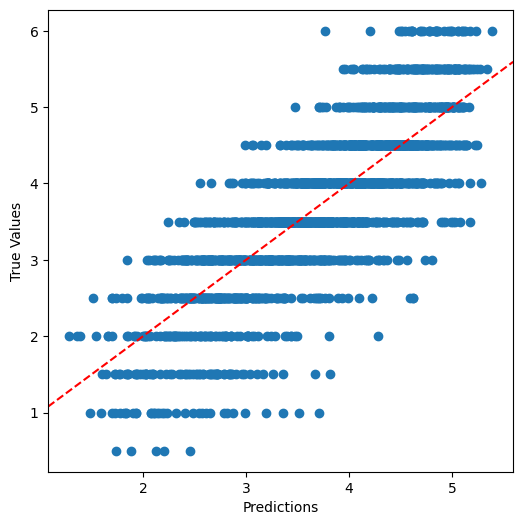

In [26]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(means, train_feats['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()

(array([494., 905., 603., 281., 115.,  43.,  20.,   3.,   5.,   2.]),
 array([0.0010648 , 0.02713728, 0.05320976, 0.07928224, 0.10535472,
        0.1314272 , 0.15749968, 0.18357216, 0.20964464, 0.23571712,
        0.2617896 ]),
 <BarContainer object of 10 artists>)

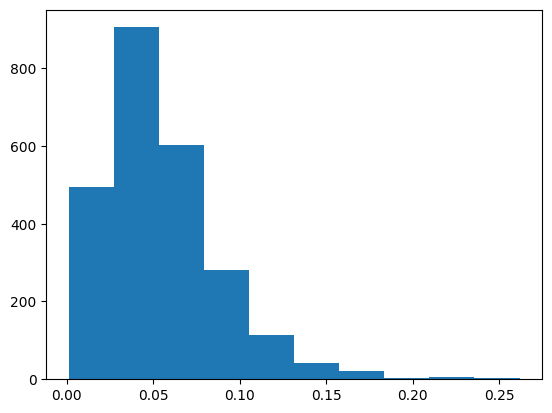

In [27]:
plt.hist(stds)

## Analyze models

In [28]:
split_importance = models_dict['0_0'].feature_importances_

# Plot feature importance using Gain
# lgb.plot_importance(models_dict['0_0'], importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
# plt.show()

In [29]:
dict_ = {}
for feat in train_cols:
    dict_[feat] = 0

for i in models_dict:
    for count, feat in enumerate(train_cols):
        dict_[feat] += models_dict[i].feature_importances_[count]

In [30]:
cols[[key for key, value in dict_.items() if value == 0]].tolist()

['down_event_14_cnt',
 'up_event_14_cnt',
 'action_time_min',
 'cursor_position_min',
 'word_len_mean']

In [31]:
split_importance_df = pd.DataFrame({'Feature': train_cols, 'Split': split_importance})
print(split_importance_df.sort_values(by='Split', ascending=False).tail(20))

     Feature  Split
16        16      3
33        33      2
115      115      2
14        14      2
15        15      2
29        29      1
88        88      1
18        18      1
55        55      1
4          4      1
49        49      1
45        45      1
118      118      0
77        77      0
76        76      0
75        75      0
123      123      0
34        34      0
28        28      0
50        50      0


In [32]:
import sys

sys.exit()

SystemExit: 

C:\Users\luis.pinto1\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Reduced feature list

In [ ]:
temp_cols = []
for k in models_dict.keys():
    temp = models_dict[k].feature_importances_
    temp_df = pd.DataFrame({'Feature': train_cols, 'Split': temp})
    temp_cols+=list(temp_df.sort_values(by='Split', ascending=False).loc[:np.ceil(temp_df.shape[0]*0.75)]['Feature'].values)
# list(split_importance_df.sort_values(by='Split', ascending=False).loc[:np.ceil(split_importance_df.shape[0]*0.75)]['Feature'].values)

new_train_cols = list(set(temp_cols))

In [ ]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in new_train_cols if col not in target_col + drop_cols]

In [ ]:
def objective(trial,data=train_feats[train_cols],target=train_feats[target_col]):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    params = {
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 5e-2, log=True), #trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [9,11,13,15,17,20,25,30,35,40,45,50]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [9,11,13,15,17,20,25,30,35,40,45,50]),
        'num_leaves': trial.suggest_int('num_leaves', 10, 40, step=2)
    }

    all_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': 42,
        "n_estimators" : 10000,
        "verbosity": -1,
        "n_jobs": -1,
        # "device_type": 'cuda',
        # "gpu_use_dp": True,
        **params
    }

    model = lgb.LGBMRegressor(**all_params)

    early_stopping_callback = lgb.early_stopping(50, first_metric_only=True, verbose=False)
    
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)],  
                callbacks=[early_stopping_callback],
    )
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-12-04 22:42:44,426] A new study created in memory with name: no-name-277e7e2c-5f76-42c5-b825-11c304a3ef71
[I 2023-12-04 22:43:04,538] Trial 0 finished with value: 0.5835678813677481 and parameters: {'reg_lambda': 1.2416310682730105, 'reg_alpha': 0.9207298246650865, 'colsample_bytree': 0.7, 'colsample_bynode': 0.4, 'subsample': 1.0, 'learning_rate': 0.004329552883749802, 'max_depth': 40, 'min_child_samples': 50, 'num_leaves': 14}. Best is trial 0 with value: 0.5835678813677481.
[I 2023-12-04 22:43:57,942] Trial 1 finished with value: 0.5827234682003812 and parameters: {'reg_lambda': 0.03435274262778796, 'reg_alpha': 2.4275459985516226, 'colsample_bytree': 0.5, 'colsample_bynode': 0.7, 'subsample': 1.0, 'learning_rate': 0.000952795712114569, 'max_depth': 13, 'min_child_samples': 15, 'num_leaves': 10}. Best is trial 1 with value: 0.5827234682003812.
[I 2023-12-04 22:47:27,292] Trial 2 finished with value: 0.6074392976181612 and parameters: {'reg_lambda': 0.03254739626141539, 'reg_

Number of finished trials: 150
Best trial: {'reg_lambda': 0.3429800108155362, 'reg_alpha': 3.194364511840987, 'colsample_bytree': 0.6, 'colsample_bynode': 0.9, 'subsample': 0.9, 'learning_rate': 0.017699188262384626, 'max_depth': 30, 'min_child_samples': 9, 'num_leaves': 12}


In [ ]:
study.trials_dataframe().sort_values(by='value', ascending=True)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bynode,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
145,145,0.574076,2023-12-04 23:40:37.223060,2023-12-04 23:40:43.394825,0 days 00:00:06.171765,0.9,0.6,0.017699,30,9,12,3.194365,0.342980,0.9,COMPLETE
54,54,0.575652,2023-12-04 23:21:02.652005,2023-12-04 23:21:14.556557,0 days 00:00:11.904552,1.0,0.4,0.007230,45,17,10,6.917574,0.117548,0.9,COMPLETE
124,124,0.575964,2023-12-04 23:36:16.817280,2023-12-04 23:36:30.947154,0 days 00:00:14.129874,1.0,0.4,0.005969,30,9,12,9.963699,0.276488,0.9,COMPLETE
136,136,0.576182,2023-12-04 23:39:23.976717,2023-12-04 23:39:35.093411,0 days 00:00:11.116694,1.0,0.6,0.012647,30,9,10,6.314529,0.974768,0.9,COMPLETE
125,125,0.576728,2023-12-04 23:36:30.948154,2023-12-04 23:36:48.521055,0 days 00:00:17.572901,1.0,0.8,0.008223,13,9,14,8.465590,0.342354,0.9,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,7,0.593613,2023-12-04 22:57:26.264460,2023-12-04 22:57:36.510887,0 days 00:00:10.246427,0.7,0.8,0.029422,11,25,28,0.000383,0.003108,0.6,COMPLETE
2,2,0.607439,2023-12-04 22:43:57.943956,2023-12-04 22:47:27.291668,0 days 00:03:29.347712,1.0,1.0,0.000211,9,40,14,0.255294,0.032547,0.6,COMPLETE
9,9,0.644155,2023-12-04 22:57:43.159823,2023-12-04 23:05:35.025058,0 days 00:07:51.865235,0.9,0.7,0.000137,45,15,36,0.000120,0.005253,1.0,COMPLETE
4,4,0.665031,2023-12-04 22:47:42.165219,2023-12-04 22:51:22.048615,0 days 00:03:39.883396,0.5,0.8,0.000117,9,40,18,0.009382,0.000190,1.0,COMPLETE


## Test best model

In [ ]:
len(train_cols)

3209

In [ ]:
import pickle

with open('reduced_train_cols.pkl', 'wb') as f:
    pickle.dump(train_cols, f)

In [ ]:
best_trial = study.best_trial.params
print(best_trial)

{'reg_lambda': 0.3429800108155362, 'reg_alpha': 3.194364511840987, 'colsample_bytree': 0.6, 'colsample_bynode': 0.9, 'subsample': 0.9, 'learning_rate': 0.017699188262384626, 'max_depth': 30, 'min_child_samples': 9, 'num_leaves': 12}


In [ ]:
OOF_PREDS = np.zeros((len(train_feats), 2))
# TEST_PREDS = np.zeros((len(test_feats), 2))

models_dict = {}
scores = []
preds_dict = {}
count = 0
for _ in train_feats['id'].unique():
    preds_dict[count] = []
    count+=1

# test_predict_list = []

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_feats.shape[0])
    # X_test = test_feats[train_cols]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]
        best_params = {
                "objective": "rmse",
                "metric": "rmse",
                'random_state': 42,
                "n_estimators" : 10000,
                "verbosity": -1,
                "n_jobs": -1,
                **best_trial
            }
        model = lgb.LGBMRegressor(**best_params)
        early_stopping_callback = lgb.early_stopping(50, first_metric_only=True, verbose=False)
        
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  
                  callbacks=[early_stopping_callback],
        )

        valid_predict = model.predict(X_valid)

        for count, idx in enumerate(valid_idx):
            preds_dict[idx].append(valid_predict[count])

        oof_valid_preds[valid_idx] = valid_predict
        # OOF_PREDS[valid_idx, 0] += valid_predict / 5
        OOF_PREDS[valid_idx, 0] = valid_predict 


        # test_predict = model.predict(X_test)
        # TEST_PREDS[:, 0] += test_predict / 5 / 10
        # test_predict_list.append(test_predict)
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
    scores.append(oof_score)

In [ ]:
means = []
stds = []

for idx in preds_dict:
    means.append(np.mean(preds_dict[idx]))
    stds.append(np.std(preds_dict[idx]))
    
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   means,
                                                                   squared=False)))

OOF metric LGBM = 0.61374


## Quantiles

In [ ]:
# OOF_PREDS1 = np.zeros((len(train_feats), 1))
# OOF_PREDS2 = np.zeros((len(train_feats), 1))
# OOF_PREDS3 = np.zeros((len(train_feats), 1))
# # TEST_PREDS = np.zeros((len(test_feats), 2))

# models_dict = {}
# scores = []
# preds_dict = {}
# preds_dict['0.1'] = {}
# preds_dict['0.5'] = {}
# preds_dict['0.9'] = {}


# for i in [0.1,0.5,0.9]:
#     count = 0
#     for _ in train_logs_df['id'].unique():
#         preds_dict[str(i)][count] = []
#         count+=1

# # test_predict_list = []

# for i in range(5):
#     kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
#     oof_valid_preds = np.zeros(train_feats.shape[0])
#     # X_test = test_feats[train_cols]
#     for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
#         X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
#         X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]
#         best_params = {
#                 "objective": "quantile",
#                 "metric": "rmse",
#                 'random_state': 42+i,
#                 # "n_estimators" : 12001,
#                 "verbosity": -1,
#                 "n_jobs": -1,
#                 **best_trial
#             }
        
#         for alpha_, oof_ in zip([0.1, 0.5, 0.9], [OOF_PREDS1, OOF_PREDS2, OOF_PREDS3]):
#             model = lgb.LGBMRegressor(**best_params, alpha=alpha_)
#             early_stopping_callback = lgb.early_stopping(50, first_metric_only=True, verbose=False)
            
#             model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
#                     callbacks=[early_stopping_callback],
#             )

#             valid_predict = model.predict(X_valid)

#             for count, idx in enumerate(valid_idx):
#                 preds_dict[str(alpha_)][idx].append(valid_predict[count])

#             # oof_valid_preds[valid_idx] = valid_predict
#             # OOF_PREDS[valid_idx, 0] += valid_predict / 5
#             oof_[valid_idx, 0] = valid_predict


#             # test_predict = model.predict(X_test)
#             # TEST_PREDS[:, 0] += test_predict / 5 / 10
#             # test_predict_list.append(test_predict)
#             # score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
#             models_dict[f'{fold}_{i}'] = model

#     # oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
#     # scores.append(oof_score)

In [ ]:
# means = []
# stds = []

# for idx in preds_dict['0.9']:
#     means.append(np.mean(preds_dict['0.9'][idx]))
#     stds.append(np.std(preds_dict['0.9'][idx]))

In [ ]:
# print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
#                                                                    means,
#                                                                    squared=False)))

OOF metric LGBM = 1.20673


## Analyze errors

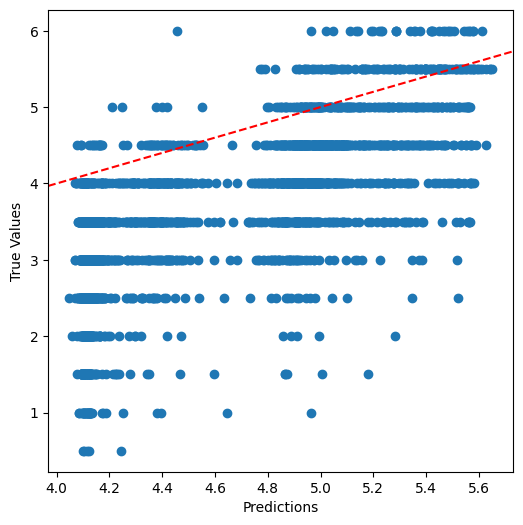

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(means, train_scores_df['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()

(array([491., 955., 596., 248., 101.,  36.,  23.,  12.,   7.,   2.]),
 array([0.00259067, 0.01846898, 0.03434728, 0.05022559, 0.0661039 ,
        0.0819822 , 0.09786051, 0.11373881, 0.12961712, 0.14549542,
        0.16137373]),
 <BarContainer object of 10 artists>)

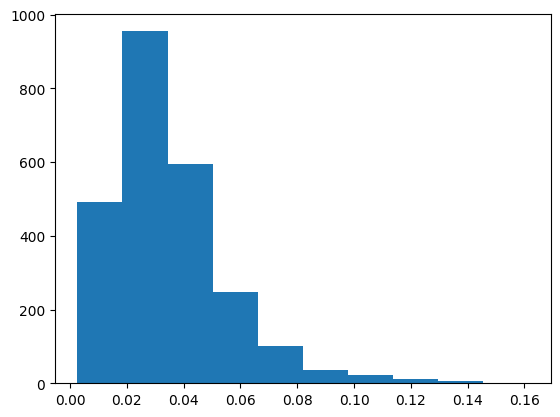

In [ ]:
plt.hist(stds)

In [ ]:
x = pd.DataFrame()
x['means'] = means
x['stds'] = stds
x['target'] = train_scores_df['score']

In [ ]:
x['residuals'] = np.abs(x['means'] - x['target'])

In [ ]:
x.sort_values(by='stds', ascending=False, inplace=True)

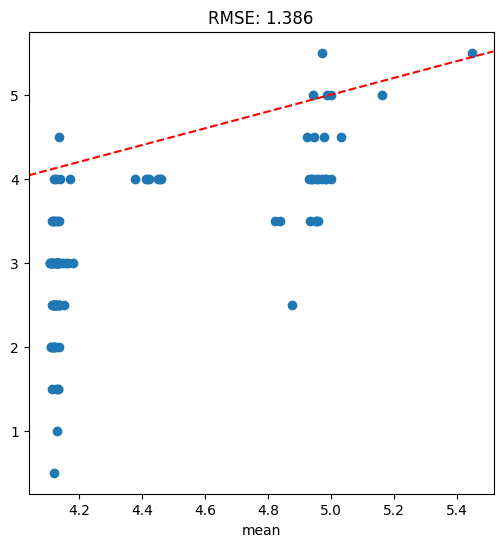

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))

x_ = x['means'].tail(100)
# x_ = round_to_half(x_, round_up=True)
y = x['target'].tail(100)

mse = metrics.mean_squared_error(x_, y, squared=False)

ax.scatter(x_, y)
plt.xlabel('mean')
plt.title(f'RMSE: {mse:.3f}')
add_identity(ax, color='r', ls='--')
plt.show()